In [1]:
from evaluation import regression_evaluator
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFECV, RFE
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [2]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)

In [3]:
def feature_selection(base_model , X_train_full, y_train):
    
    cv = KFold(n_splits=5, shuffle=True, random_state=44449999)
    rfecv = RFECV(estimator=base_model, step=1, cv=cv, scoring='r2')
    rfecv.fit(X_train_full, y_train)
    gr = rfecv.cv_results_
    
    num_features = list(range(1, len(gr['mean_test_score']) + 1))
    mean_minus_std = np.array(gr['mean_test_score']) - np.array(gr['std_test_score'])
    
    idx = np.argmax(mean_minus_std)
    
    num_features_selected = num_features[idx]
    
    rfe = RFE(estimator=base_model, n_features_to_select=num_features_selected, step=1)
    rfe.fit(X_train_full, y_train)
    selected_cols = X_train_full.columns[(rfe.support_)]
    return selected_cols
    

In [4]:
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    
    model = xgb.XGBRegressor(
        **params,
        seed=4455542111
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse = np.abs(scores.mean())
    
    return {'loss': rmse, 'status': STATUS_OK}


def objective2(params):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='rmse', seed=0)
    return cv_result['test-rmse-mean'].min()

In [5]:
data = pd.read_csv("fourth_down_dataset.csv")
print(data['play_type'].value_counts())


passing = partition(data,'pass')
run = partition(data,'run')
fg = partition(data,'field_goal')
punt = partition(data,'punt')

partitioned_dataset = [("run", run) , 
                       ("pass", passing), 
                       ("fg", fg), ("punt", punt)]

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
no_play        1364
qb_kneel         20
Name: count, dtype: int64


In [6]:
param_space = {
        'objective': 'reg:squarederror',
        'eta': hp.uniform('eta',0.001, 0.1),
        'max_depth': hp.quniform("max_depth", 3, 13, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 25)
    }

Producing run model...
Number of Features: 22
Index(['year', 'week', 'yardline_100', 'half_seconds_remaining',
       'game_seconds_remaining', 'drive', 'ydstogo', 'ydsnet',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'score_differential', 'no_score_prob', 'fg_prob', 'ep',
       'drive_play_count', 'spread_line', 'posteam_is_home',
       'posteam_spread_line', 'wp_avg', 'wp_difference',
       'posteam_rush_epa_per_sec', 'posteam_pass_epa_per_sec'],
      dtype='object')
100%|██████| 100/100 [05:45<00:00,  3.45s/trial, best loss: 0.05306458816125775]
{'colsample_bytree': 0.7146330594996142, 'eta': 0.05254707896179342, 'max_depth': 4.0, 'min_child_weight': 8.0, 'n_estimators': 625.0}
Evaluation for (Train)
Max Error: 0.06839640130512237
Mean Absolute Error: 0.008492260942331758
Mean Squared Error for +wpa: 0.00011834007318701349
Mean Squared Error for -wpa: 0.0002098627669711868
Regression Accuracy: 0.9385692068429238
Mean Squared Error: 0.000148017338589

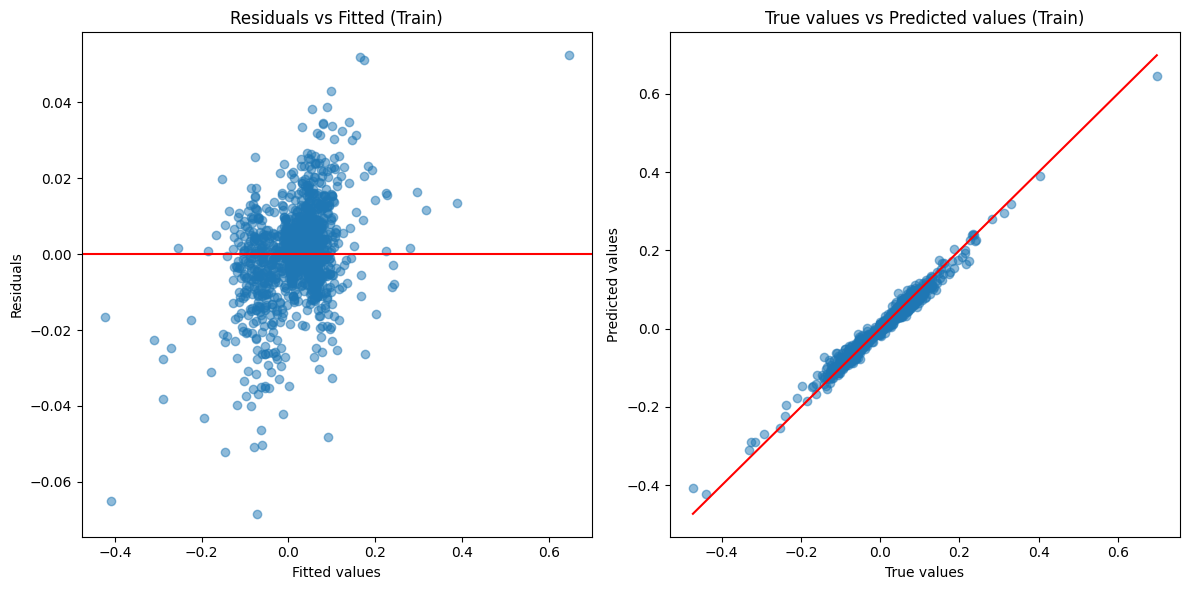

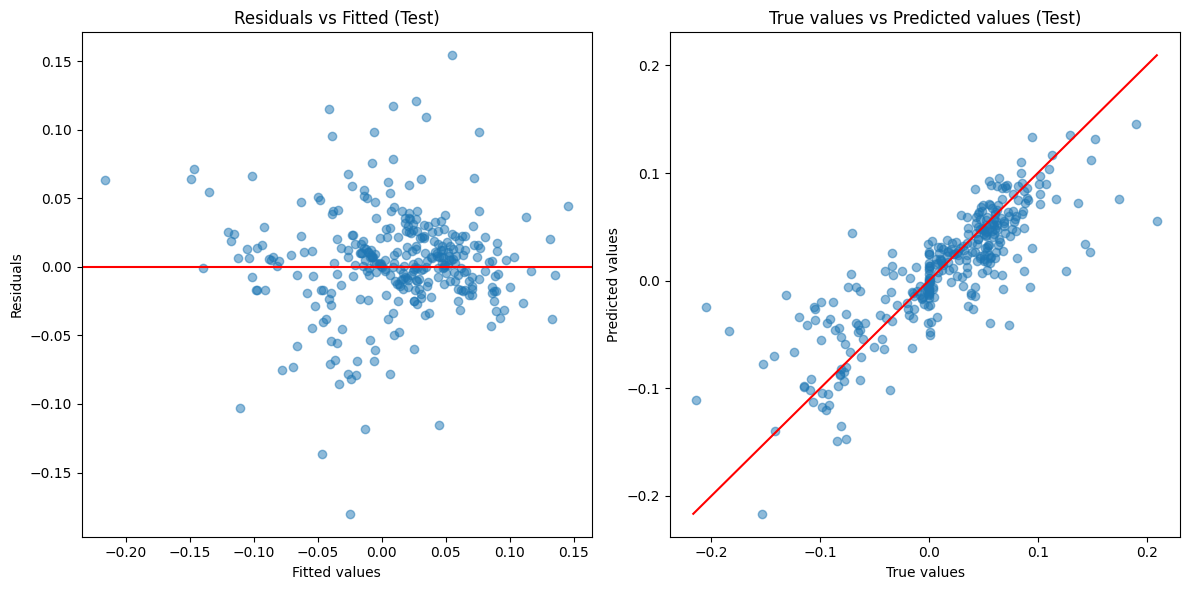

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Producing pass model...
Number of Features: 13
Index(['yardline_100', 'game_seconds_remaining', 'drive', 'ydstogo', 'ydsnet',
       'score_differential', 'no_score_prob', 'drive_play_count',
       'posteam_is_home', 'posteam_spread_line', 'wp_avg', 'wp_difference',
       'posteam_pass_epa_per_sec'],
      dtype='object')
100%|██████| 100/100 [07:18<00:00,  4.38s/trial, best loss: 0.06020028582212591]
{'colsample_bytree': 0.824638879403622, 'eta': 0.059679873769421285, 'max_depth': 5.0, 'min_child_weight': 5.0, 'n_estimators': 525.0}
Evaluation for (Train)
Max Error: 0.08077544650948525
Mean Absolute Error: 0.007114852344078033
Mean Squared Error for +wpa: 0.00015328968725613162
Mean Squared Error for -wpa: 8.71842888922954e-05
Regression Accuracy: 0.9225058004640371
Mean Squared Error: 0.00011770627096747733
Root Mean Squared Error: 0.010849252092539712
R-Squared: 0.9852741950605585
----------------------------
Evaluation for (Test)
Max Error: 0.5633393834957076
Mean Absolute Error:

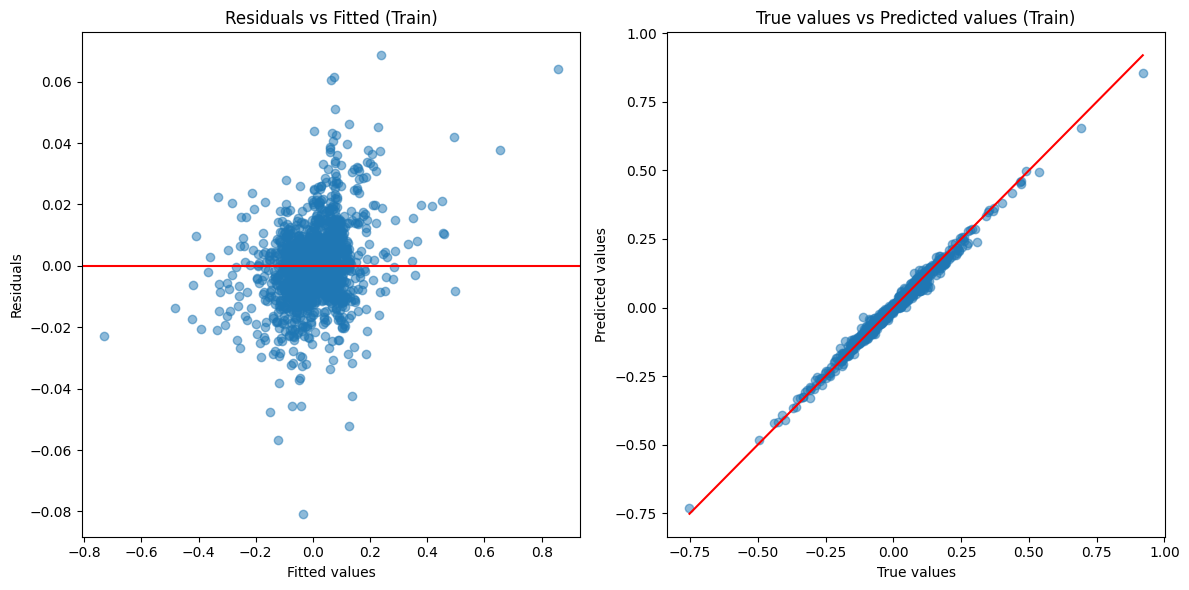

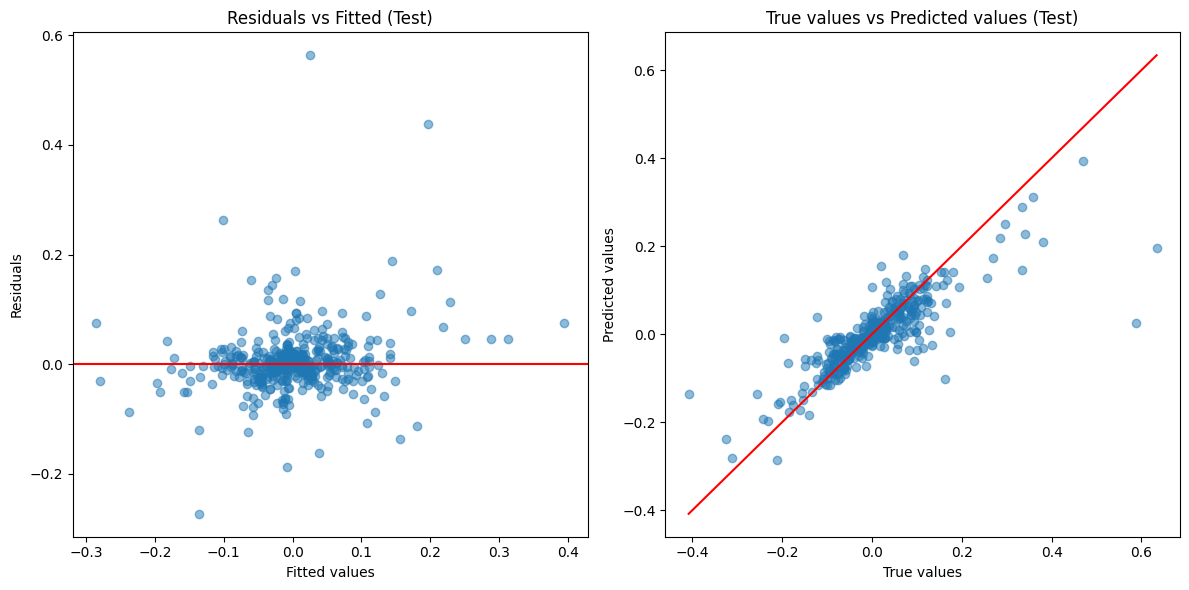

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:09:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Producing fg model...
Number of Features: 17
Index(['year', 'yardline_100', 'half_seconds_remaining',
       'game_seconds_remaining', 'drive', 'ydstogo', 'ydsnet',
       'defteam_timeouts_remaining', 'score_differential', 'no_score_prob',
       'fg_prob', 'drive_play_count', 'spread_line', 'posteam_is_home',
       'wp_avg', 'wp_difference', 'posteam_pass_epa_per_sec'],
      dtype='object')
100%|██████| 100/100 [09:53<00:00,  5.94s/trial, best loss: 0.04940065526371987]
{'colsample_bytree': 0.629104760502881, 'eta': 0.03908199366936537, 'max_depth': 6.0, 'min_child_weight': 7.0, 'n_estimators': 750.0}
Evaluation for (Train)
Max Error: 0.12170494987804412
Mean Absolute Error: 0.008184651320233539
Mean Squared Error for +wpa: 0.0001137545287665073
Mean Squared Error for -wpa: 0.0001859827046517727
Regression Accuracy: 0.9069212410501193
Mean Squared Error: 0.00014169612946154488
Root Mean Squared Error: 0.011903618334840247
R-Squared: 0.9655111312109094
----------------------------
E

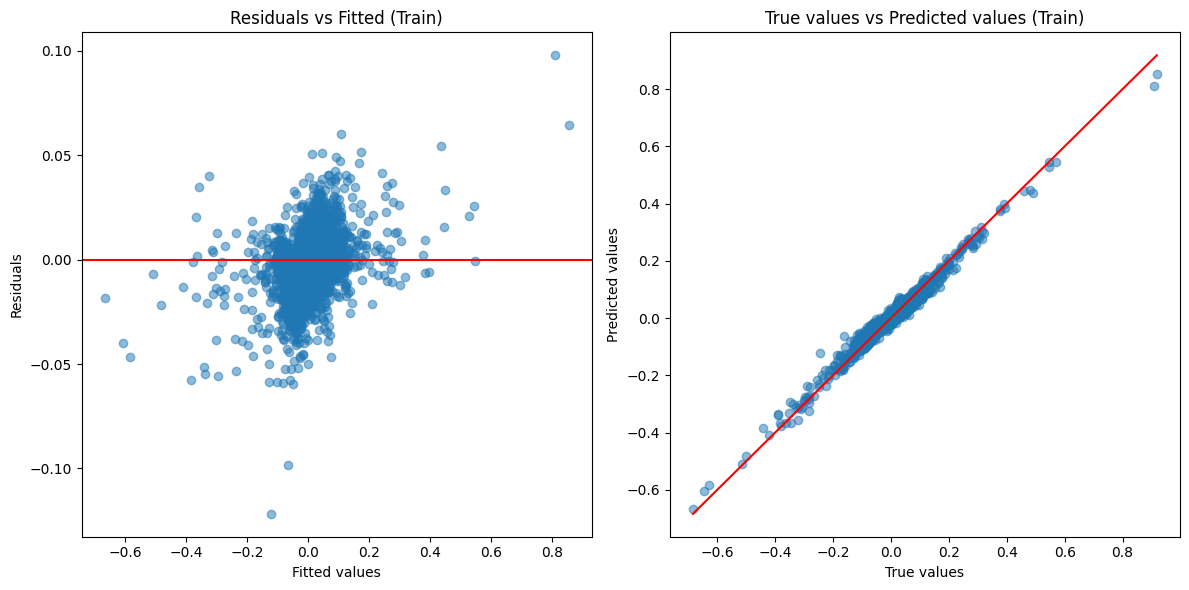

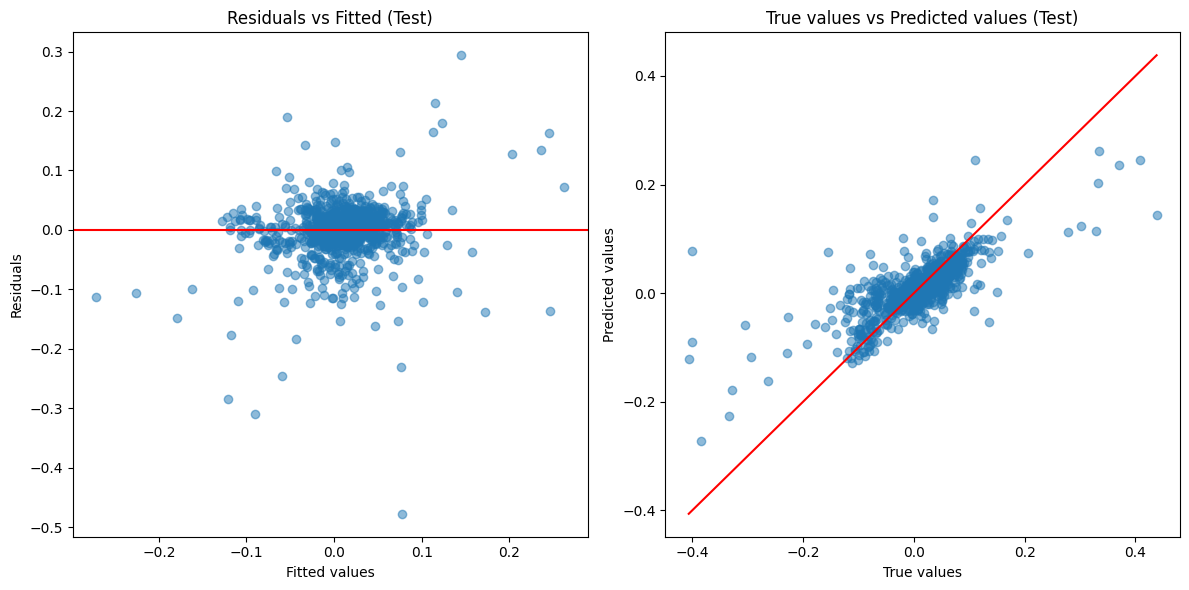

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Producing punt model...
Number of Features: 16
Index(['yardline_100', 'half_seconds_remaining', 'game_seconds_remaining',
       'drive', 'ydstogo', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'score_differential', 'no_score_prob',
       'fg_prob', 'td_prob', 'spread_line', 'posteam_is_home', 'wp_avg',
       'wp_difference', 'posteam_pass_epa_per_sec'],
      dtype='object')
100%|█████| 100/100 [10:56<00:00,  6.57s/trial, best loss: 0.026185732680962203]
{'colsample_bytree': 0.7661927741672023, 'eta': 0.07021562471628297, 'max_depth': 5.0, 'min_child_weight': 9.0, 'n_estimators': 1000.0}
Evaluation for (Train)
Max Error: 0.12386260149230954
Mean Absolute Error: 0.007771210510741997
Mean Squared Error for +wpa: 0.000118883252435777
Mean Squared Error for -wpa: 0.00013706359969195382
Regression Accuracy: 0.8542755787901419
Mean Squared Error: 0.00012743541541410737
Root Mean Squared Error: 0.011288729574850633
R-Squared: 0.9294706328952983
-----------------------

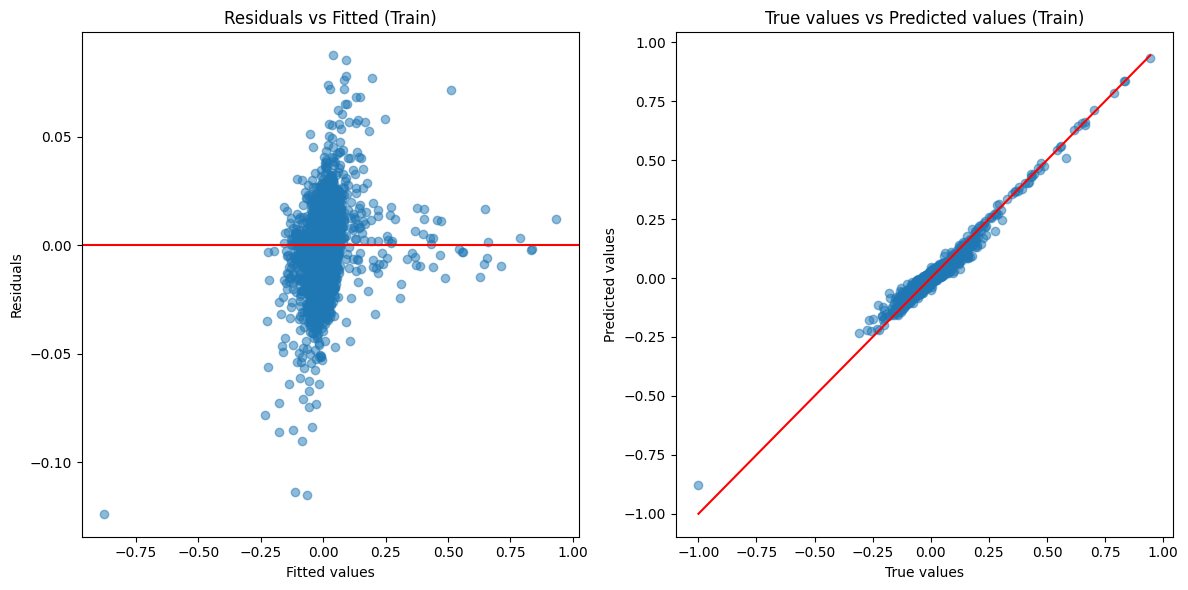

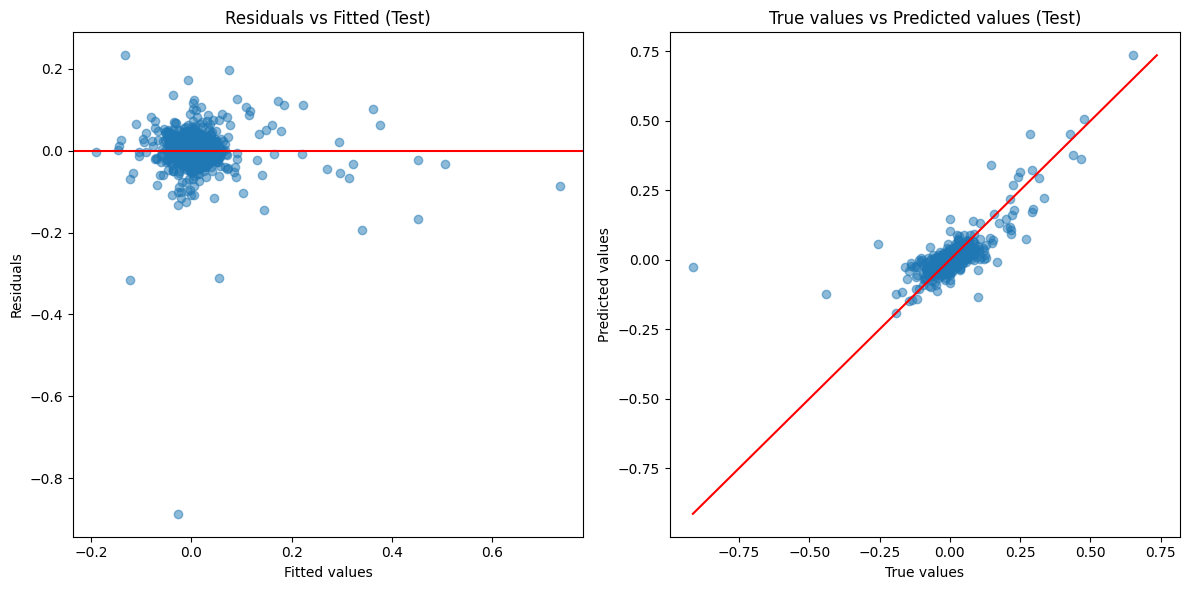

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [8]:
for name, play_data in partitioned_dataset: 
    
    print(f"Producing {name} model...")
    y = play_data['wpa_avg'].to_numpy()
    X = play_data.drop('wpa_avg', axis=1)
    cols = X.columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    xg = xgb.XGBRegressor(objective='reg:squarederror',random_state=44449999)
    
    
    cols = feature_selection(xg, X_train, y_train)
    
    print(f"Number of Features: {len(cols)}\n{cols}")
    
    re = regression_evaluator(col_names=cols)
    X_train_sel = X_train[cols]
    X_test_sel = X_test[cols]
    
    
    
    trials = Trials()
    final_params = fmin(fn=objective,
                        space=param_space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)
    
    print(final_params)
    
    final_params['max_depth'] = int(final_params['max_depth'])
    final_params['n_estimators'] = int(final_params['n_estimators'])

    best_model = xgb.XGBRegressor(**final_params)
    best_model.fit(X_train_sel, y_train)
    re.evaluate(best_model, X_train_sel, X_test_sel, y_train, y_test,clear=True, pr=True)
    
    
    best_model.save_model(f"{name}_model_v2.model")
    
    
    
    
    